In [7]:
import xarray as xr 
import pandas as pd
import numpy as np  


In [2]:
from dask.distributed import Client

client = Client()

import s3fs, dask
fs = s3fs.S3FileSystem(anon=False, use_listings_cache=False, asynchronous=True)
dask.config.set(
    {"s3.multipart_chunksize": "50MB"})

In [3]:
fn = '../data/sample_assets.csv'
loss_function = 'HOTHAPS'


## read csv  
df_in = pd.read_csv(fn)[['asset_id','latitude','longitude','asset_type']]
df_in = df_in.drop_duplicates('asset_id').rename(columns={'latitude':'lat','longitude':'lon'})
## load asset map 
asset_map = pd.read_csv('../src/asset_map.csv')

## load aircon
aircon = xr.open_zarr('s3://hazard-science-data/productivity_loss_v2/aircon/AirCon_SSPs.zarr/') 
aircon = aircon.sel(SSP='2.0').isel(year=0)['ac_penetration']

## load losses
ds_dict = {}
for scenario in ['ssp126','ssp245','ssp370','ssp585']:
    ds_dict[scenario] = {}
    for intensity in ['low','moderate','high']:
        ds_dict[scenario][intensity] = xr.open_zarr(f"s3://hazard-science-data/productivity_loss_v2/climate_outputs/projections_corrected/{scenario}/CMIP6-ScenarioMIP_{loss_function}_productivity_loss_{intensity}_{scenario}.zarr.zarr/")

In [145]:
## output
df_out = df_in.copy(deep=True).set_index('asset_id')
df_out['work_intensity'] = df_out['asset_type'].map(asset_map.set_index('asset_type').to_dict()['intensity'])
df_out=df_out.reset_index()
## sample
df_out_ssp126 = df_out.copy(deep=True)
df_out_ssp126 = df_out_ssp126.loc[:40,:] # trim for testing

In [147]:
scenarios = ['ssp126','ssp585']
df_out = {}
for scenario in scenarios:
    df_out[scenario] = df_in.loc[:40,:].copy(deep=True).set_index('asset_id')
    df_out[scenario]['work_intensity'] = df_out[scenario]['asset_type'].map(asset_map.set_index('asset_type').to_dict()['intensity'])
    df_out[scenario]=df_out[scenario].reset_index()

  
def extract_values(row):
    """Fetches nearest productivity loss values for given lat, lon, and work intensity."""
    ds = ds_dict[scenario][row['work_intensity']]
    result = {f"{year}_{stat}": np.round(ds.sel(lat=row['lat'], lon=row['lon'], year=year, method='nearest')[stat].values,4)
            for stat in newcols for year in years }
    return pd.Series(result)

for scenario in scenarios:
    years = ds_dict[scenario]['high'].year.values
    newcols = ['median', 'minimum', 'maximum']
    # Create new columns in one operation
    col_names = [f"{year}_{stat}" for year in years for stat in newcols]
    df_out[scenario] = df_out[scenario].assign(**{col: np.nan for col in col_names})
    # apply function across all rows
    df_out[scenario][col_names] = df_out[scenario].apply(extract_values, axis=1)


In [140]:
df_out[scenario].set_index("asset_id").drop(
    columns=["lat", "lon"]
).transpose().to_csv(f"../output_csvs/unscaled_{scenario}.csv")


In [148]:
df_out[scenario]

,asset_id,lat,lon,asset_type,work_intensity,2025_median,2025_minimum,2025_maximum,2030_median,2030_minimum,...,2070_maximum,2080_median,2080_minimum,2080_maximum,2090_median,2090_minimum,2090_maximum,2100_median,2100_minimum,2100_maximum
0,1203 - BP INTERNATIONAL LIMITED,51.734730,5.494284,HIGH_ST,low,0.0228,0.0228,0.0228,0.0228,0.0228,...,0.0228,0.0228,0.0228,0.0228,0.0228,0.0228,0.0228,0.0457,0.0913,0.1142
1,19238 - BP INTERNATIONAL LIMITED,51.935600,4.125400,ONSHORE_WIND,high,0.0228,0.0228,0.0228,0.0228,0.0228,...,0.0457,0.0457,0.0708,0.0708,0.0913,0.1164,0.2306,0.3904,0.7100,0.8790
2,21 - DP WORLD LIMITED,51.550000,4.460072,OFFICE,low,0.0228,0.0228,0.0228,0.0228,0.0228,...,0.0228,0.0228,0.0228,0.0228,0.0228,0.0228,0.0228,0.0457,0.0685,0.0913
3,5420 - BP INTERNATIONAL LIMITED,51.914513,4.546143,HIGH_ST,low,0.0228,0.0228,0.0228,0.0228,0.0228,...,0.0228,0.0228,0.0228,0.0228,0.0228,0.0228,0.0228,0.0228,0.0457,0.0708
4,72 - ABU DHABI NATIONAL ENERGY COMPANY - P.J.S.C,24.090403,52.652494,ENERGY,high,11.7237,13.2763,14.0297,14.3836,16.4498,...,16.1598,17.5845,18.0274,20.2358,21.8151,26.3493,31.7808,34.9680,41.1416,42.3014
5,92 - MINOR INTERNATIONAL PUBLIC COMPANY LIMITED,25.127070,55.115090,HOTEL,low,2.0976,2.4543,2.7511,3.1919,3.7847,...,4.0091,4.5868,5.6256,7.4406,8.5708,13.0708,17.8059,22.6804,27.8470,29.8858
6,3 - Endeavour Trade and Investment Ltd,25.069283,55.141722,OFFICE,low,2.2945,2.6027,2.8539,3.2648,3.6416,...,4.3288,5.0571,5.6804,7.5457,8.4817,12.8584,16.5913,21.6096,27.3470,28.8721
7,321 - DP WORLD LIMITED,25.070000,55.141254,OFFICE,low,2.2945,2.6027,2.8539,3.2648,3.6416,...,4.3288,5.0571,5.6804,7.5457,8.4817,12.8584,16.5913,21.6096,27.3470,28.8721
8,19079 - BP INTERNATIONAL LIMITED,43.368440,-86.153485,HIGH_ST,low,0.0228,0.0228,0.0228,0.0228,0.0228,...,0.0251,0.0457,0.0457,0.0685,0.0913,0.1366,0.2078,0.3653,0.6870,1.0457
9,20891 - BP INTERNATIONAL LIMITED,35.685001,-114.467598,HIGH_ST,low,0.0457,0.0683,0.0685,0.0685,0.0913,...,0.1142,0.1142,0.1142,0.1594,0.1826,0.2991,0.4635,0.8472,1.3082,1.7968


In [149]:
### ac scaling
residential = 1
commercial = 1.5

df_scaled = {}
for scenario in scenarios:
    df_scaled[scenario] = df_out[scenario].copy(deep=True)
    df_scaled[scenario]['AC_penetration'] = np.full_like(df_scaled[scenario]['lat'],np.nan)
    for i in df_scaled[scenario].index:
        df_scaled[scenario].loc[i,'AC_penetration'] = np.round(aircon.sel(lat=df_scaled[scenario].loc[i,'lat'],lon=df_scaled[scenario].loc[i,'lat'],method='nearest').values,3)
        if not pd.isna(df_scaled[scenario].loc[i,'AC_penetration']):
            df_scaled[scenario].iloc[i,5:-1] *= 1-df_scaled[scenario].iloc[i,-1]



In [64]:
if not pd.isna(df_scaled[scenario].loc[446,'AC_penetration']):
    print('not')

In [118]:
import seaborn as sns 
import random


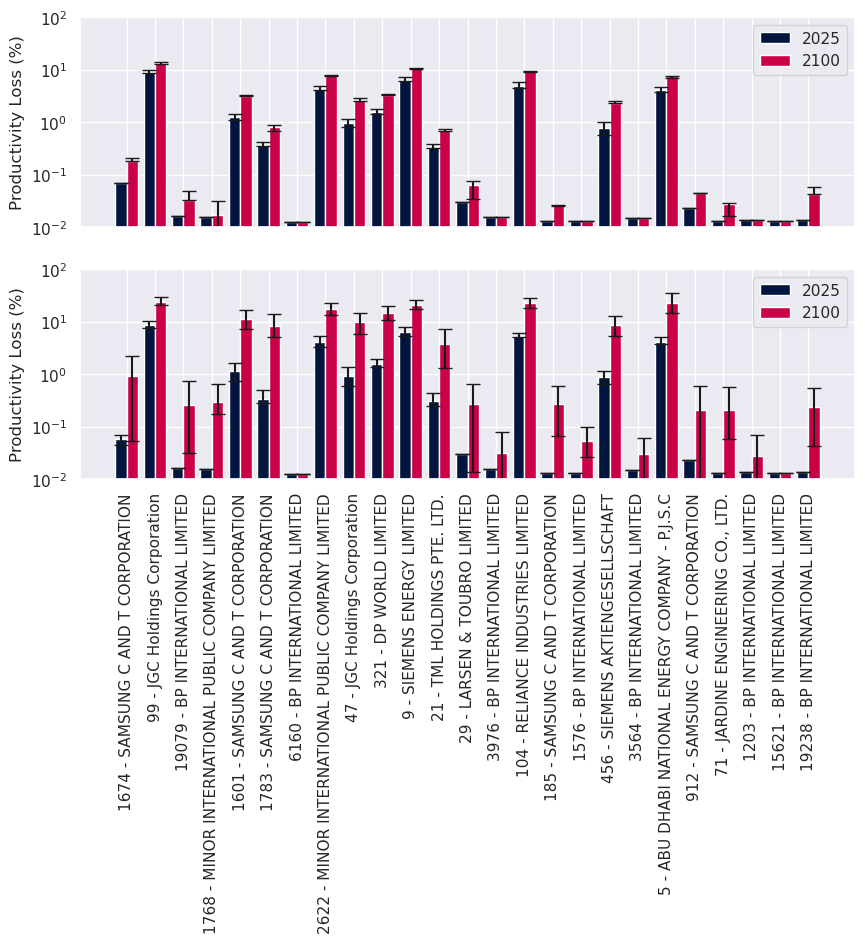

In [150]:
f,ax = plt.subplots(len(scenarios),1,figsize=(10,3*len(scenarios)),sharex=True)
ids = random.sample(list(df_scaled[scenarios[0]].index),25)

for i, scenario in enumerate(scenarios):
    data = df_scaled[scenario].loc[ids]
    median_columns = [col for col in data.columns if ("2025" in col) or ("2100" in col)]
    median_columns.append('asset_id')
    data = data[median_columns]
    #data["asset_id"] = data["asset_id"].str.split(" - ").str[0]

    # Define x-axis positions
    x = np.arange(len(data))

    # Define error bars correctly (ensure no negative values)
    err_2025 = [np.abs(data["2025_median"] - data["2025_minimum"]), np.abs(data["2025_maximum"] - data["2025_median"])]
    err_2100 = [np.abs(data["2100_median"] - data["2100_minimum"]), np.abs(data["2100_maximum"] - data["2100_median"])]

    # Plot bars with error bars
    bar_width = 0.4

    if len(scenarios)>1:
        a = ax[i]
    else:
        a = ax

    a.bar(x - bar_width / 2, data["2025_median"], yerr=err_2025, width=bar_width, capsize=5, label="2025", color="xkcd:navy")
    a.bar(x + bar_width / 2, data["2100_median"], yerr=err_2100, width=bar_width, capsize=5, label="2100", color="xkcd:ruby")

    a.set_xticks(x)
    a.set_xticklabels(data['asset_id'],rotation=90);
    a.set_ylim(0.01,100)
    a.set_yscale('log')
    a.set_ylabel('Productivity Loss (%)')
    a.legend()
